# Load Data

In [105]:
save_plots = True

In [106]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import special
from inspect import signature
from datetime import datetime
import time
from tqdm import tqdm
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as md

In [107]:
## Set plot styles

%matplotlib inline
plt.rcParams['figure.dpi'] = 200
matplotlib.rcParams['axes.linewidth'] = 0.75 #set the value globally
matplotlib.rcParams['xtick.major.width'] = 0.75
matplotlib.rcParams['ytick.major.width'] = 0.75
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['legend.fontsize'] =5
matplotlib.rcParams['pdf.fonttype']=42


matplotlib.rcParams['figure.figsize'] = (3.4908516673585166, 2.327234444905678)
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rc('font', size= 7)
#params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
#plt.rcParams.update(params)

In [108]:
! ls Eu152/*.Spe

Eu152/Eu152_20231102_0_000.Spe Eu152/Eu152_20231102_0_001.Spe


In [109]:
#path = '.'
files_list = glob.glob('Eu152/*')
print(files_list)
filename_suffix_save = 'Eu152_20231101'

['Eu152/Eu152_20231102_0_001.Spe', 'Eu152/Eu152_20231102_0_000.Spe']


In [110]:
def load_file(file):
    number_lines_header = 12 ## There are 12 header lines in the SPE file
    counts_list = []

    with open(file) as fp:
        for i, line in enumerate(fp):
            line = line.rstrip('\n')
            if i == 1: ## description of the sample
                descr = line
                #print(descr)
            elif i == 7: ## starting acquisition time
                string_time = line
                #print(string_time)
                # TODO: convert to UNIX time
            elif i == 9: ## acquisition time
                live_time = int(line.split(' ')[0]) ## acquisition live time in seconds (without dead time)
                real_time = int(line.split(' ')[1]) ## acquisition real time in seconds
                #print(live_time, real_time)
            elif i == 11: ## channel numbers
                first_channel = int(line.split(' ')[0]) ## number of first channel, usually 0
                last_channel = int(line.split(' ')[1]) ## number of last channel, usually 16383 (= 2^14-1)
                #print(first_channel, last_channel)
            elif (i >= number_lines_header):
                if (i<=last_channel+number_lines_header):
                    counts_list.append(int(line))
                elif i > last_channel+number_lines_header:
                    break

    channels_list = np.arange(0, last_channel+1)
    df = pd.DataFrame(data={'channel': channels_list, 'counts': counts_list})
    
    return df, live_time, string_time, descr

def load_files(files_list):
    for i_file, file in enumerate(files_list):
        if i_file == 0:
            df_combined, live_time_combined = load_file(file)[0:2]
        else:
            df_temp, live_time_temp = load_file(file)[0:2]
            if len(df_combined) == len(df_temp):
                df_combined.counts = df_combined.counts + df_temp.counts
                live_time_combined = live_time_combined + live_time_temp
            else:
                raise ValueError("file "+str(file)+" has different number of channels compared to previous file")
                
    print('total live time = '+str(live_time_combined)+' s = '+str(live_time_combined/(24*60*60))+' d')
    return df_combined, live_time_combined

In [111]:
df, total_live_time = load_files(files_list)
df

total live time = 1800 s = 0.020833333333333332 d


,channel,counts
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
16379,16379,0
16380,16380,0
16381,16381,0
16382,16382,0


In [112]:
## Trigger Rate [s^-1]
df.loc[545:16380].counts.sum()/total_live_time

1971.0188888888888

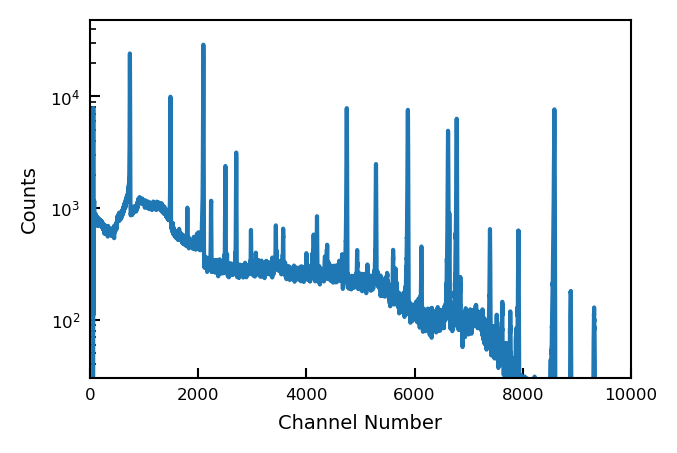

In [113]:
plt.plot(df.channel, df.counts)
plt.yscale('log')
#plt.xscale('log')
plt.xlim(0,10000)
plt.ylim(bottom = 30)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
plt.show()

# Fit Individual Peaks

In [114]:
def gausFunc(E, Gamma,P,sigma,C):
    gaus = Gamma * np.exp(-(E-P)**2/(2*sigma**2)) + C
    return gaus

#def tailFunc(E, Gamma,P,sigma,beta,C):
#    tail = Gamma * np.exp((E-P)/beta)*special.erfc(((E-P)/beta)+(sigma/(np.sqrt(2)*beta))) + C
#    return tail

from scipy.stats import crystalball
def crystalballFunc(E, Gamma,P,sigma,alpha,n,C):
    ## https://scipy.github.io/devdocs/generated/scipy.stats.crystalball.html
    crys = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + C
    return crys

def stepFunc(E, S,P,sigma,C):
    step = S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + C
    return step

def linFunc(E, m,q):
    lin = m*E+q
    return lin

def gausStepFunc(E, Gamma,S,P,sigma,C):
    gausStep = Gamma * np.exp(-(E-P)**2/(2*sigma**2)) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + C
    return gausStep

def fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q
    return res

In [115]:
df_calibration = pd.DataFrame(data={'name': [], 'e_lit': [], 'e_err_lit': [], 
                                    'peak_position': [], 'peak_position_unc': [], 
                                    'peak_width': [], 'peak_width_unc': [], 
                                    'chi2_dof': [], 'channel_max': []})

## Sm121

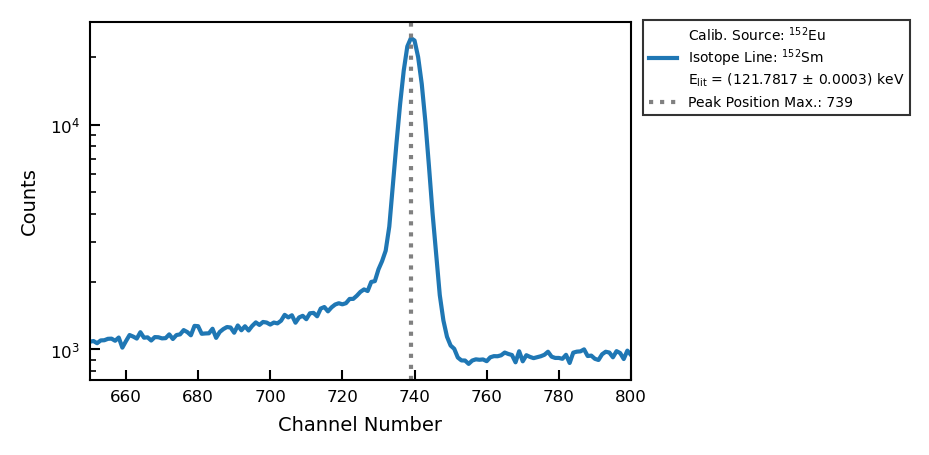

In [116]:
name = 'Sm121'
isotope = '$^{152}$Sm'
e_lit = 121.7817 #keV
e_err_lit = 0.0003 #keV

#######################
## Adjust these values if necessary:
lower_channel = 650
upper_channel = 800
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [117]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 10. ##random guess, seems to work
guess_n = 8. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = 0
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-0.1,0.1]
limits_q = [-np.inf,+np.inf]

In [118]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[6.41845109e+08 7.39298120e+02 2.83240051e+00 1.78792729e+00
 1.00001147e+00 6.53589319e+01 1.00000000e-01 8.62762634e+02]
Appending data for Sm121 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_3385/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


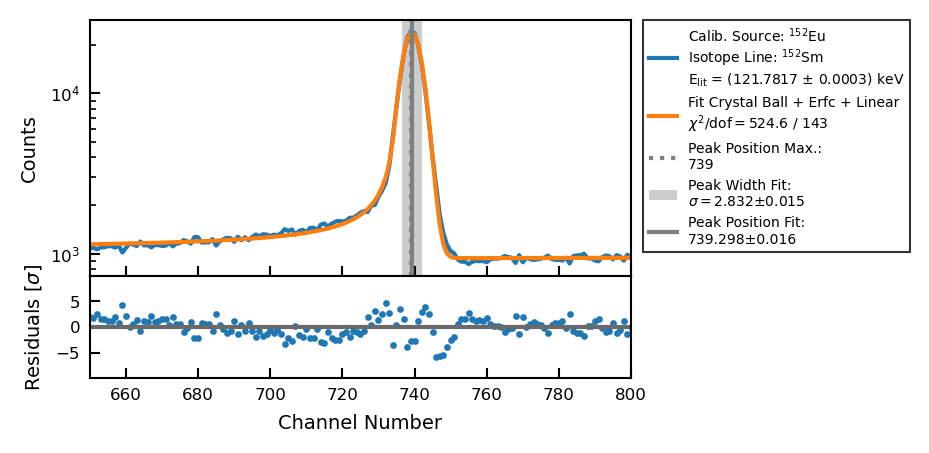

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max
0,Sm121,121.7817,0.0003,739.29812,0.016317,2.832401,0.014582,3.668584,739.0


In [119]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
#yticks[-1].label1.set_visible(False)
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()
df_calibration

## Sm 244

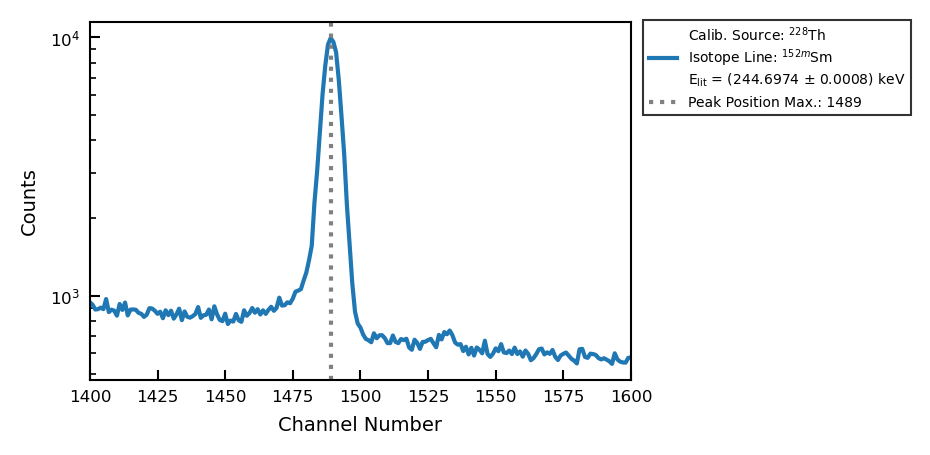

In [120]:
name = 'Sm244'
isotope = '$^{152m}$Sm'
e_lit = 244.6974 #keV
e_err_lit = 0.0008 #keV

#######################
## Adjust these values if necessary:
lower_channel = 1400
upper_channel = 1600
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [121]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,0]
limits_q = [-np.inf,+np.inf]

In [122]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 7.71139766e+04  1.48922877e+03  3.08914306e+00  1.76354006e+00
  1.67522546e+00  2.51209134e+01 -1.41714272e+00  2.82154950e+03]
Appending data for Sm244 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_3385/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


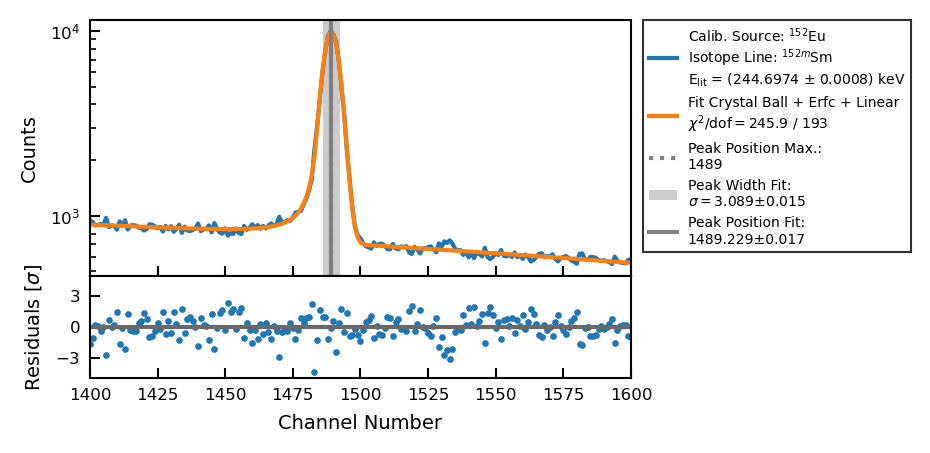

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max
0,Sm121,121.7817,0.0003,739.298120,0.016317,2.832401,0.014582,3.668584,739.0
1,Sm244,244.6974,0.0008,1489.228772,0.017237,3.089143,0.015242,1.274340,1489.0


In [123]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()
df_calibration

## Gd 344

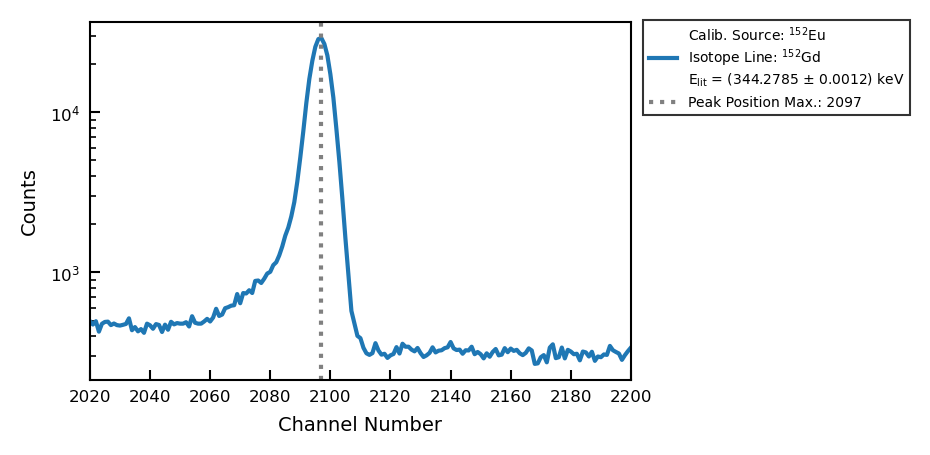

In [124]:
name = 'Gd344'
isotope = '$^{152}$Gd'
e_lit = 344.2785 #keV
e_err_lit = 0.0012 #keV

#######################
## Adjust these values if necessary:
lower_channel = 2020
upper_channel = 2200
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [125]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 5. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [126]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 2.64239462e+05  2.09660828e+03  3.35167924e+00  1.65622227e+00
  1.67657895e+00  2.09496258e+01 -3.46075626e-01  1.06301222e+03]
Appending data for Gd344 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_3385/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


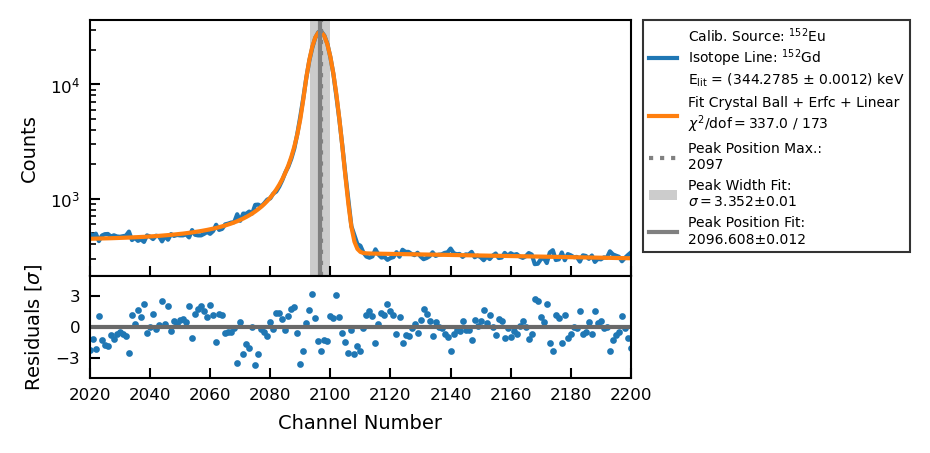

In [127]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Gd 778

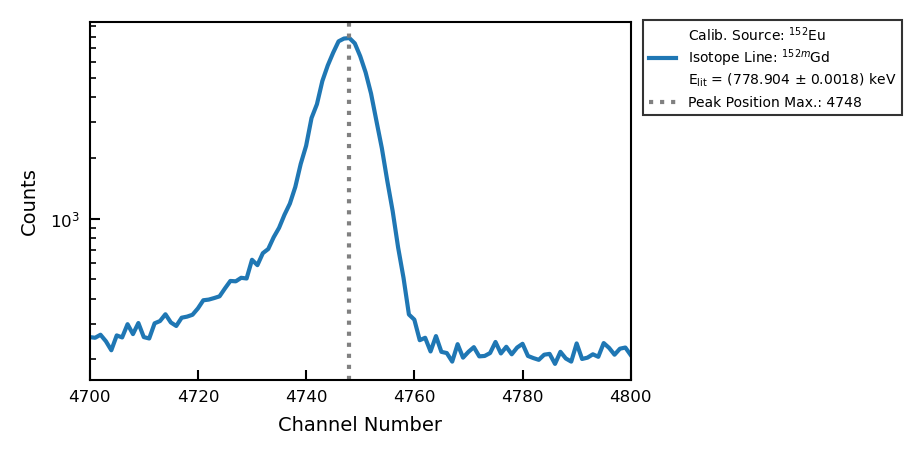

In [128]:
name = 'Gd778'
isotope = '$^{152m}$Gd'
e_lit = 778.9040 #keV
e_err_lit = 0.0018 #keV

#######################
## Adjust these values if necessary:
lower_channel = 4700
upper_channel = 4800
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [129]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [130]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 9.08383822e+04  4.74720209e+03  4.18511608e+00  1.30317270e+00
  2.34932068e+00 -4.36392395e+00 -9.28549475e-02  6.60203901e+02]
Appending data for Gd778 to df_calibration.


/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_3385/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


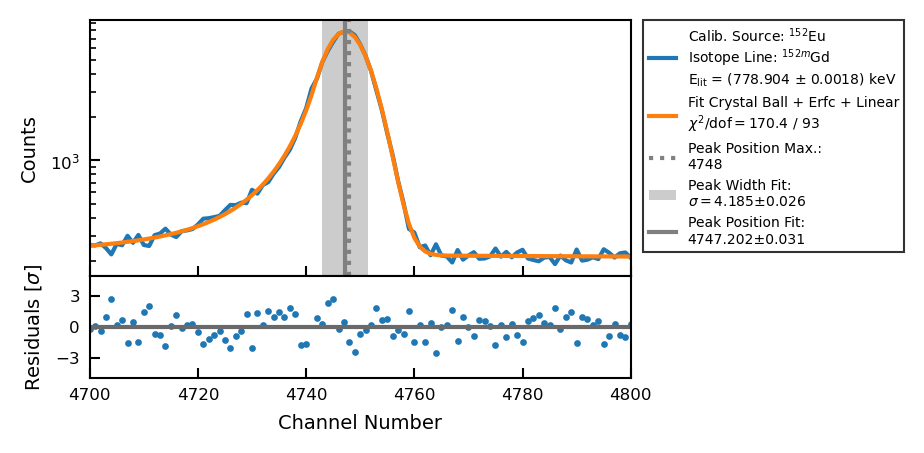

In [131]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Sm 867

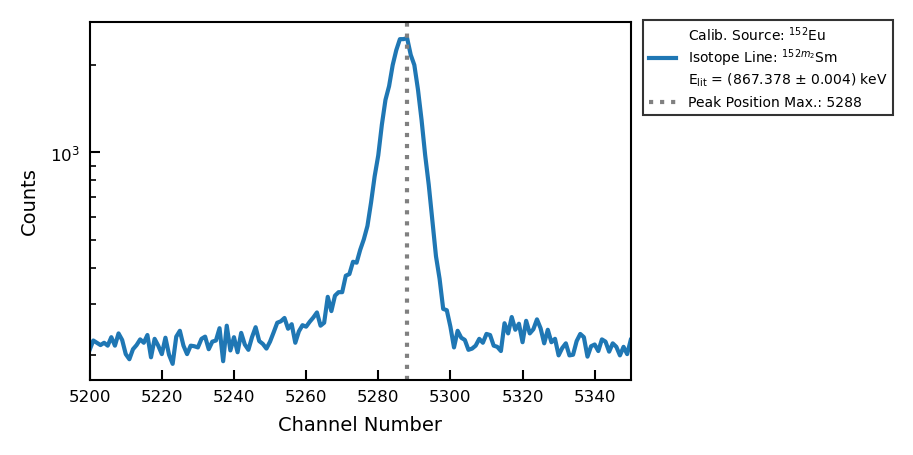

In [132]:
name = 'Sm867'
isotope = '$^{152m_{2}}$Sm'
e_lit = 867.378 #keV
e_err_lit = 0.004 #keV

#######################
## Adjust these values if necessary:
lower_channel = 5200
upper_channel = 5350
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [133]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit 
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 2 ##random guess, seems to work
guess_n = 2 ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel) 
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [134]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 2.76688551e+04  5.28673450e+03  4.33210609e+00  1.21920361e+00
  2.97501157e+00 -5.00000000e+00 -1.47617481e-02  3.00759332e+02]
Appending data for Sm867 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_3385/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


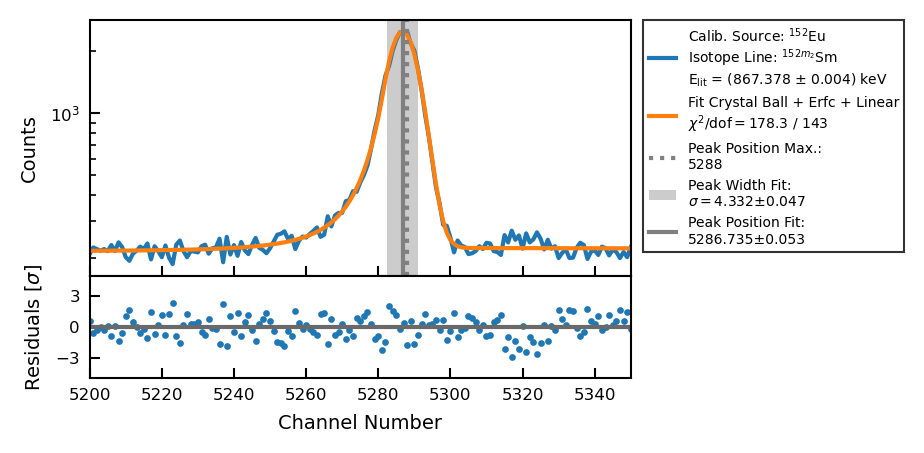

In [135]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

## Sm 964

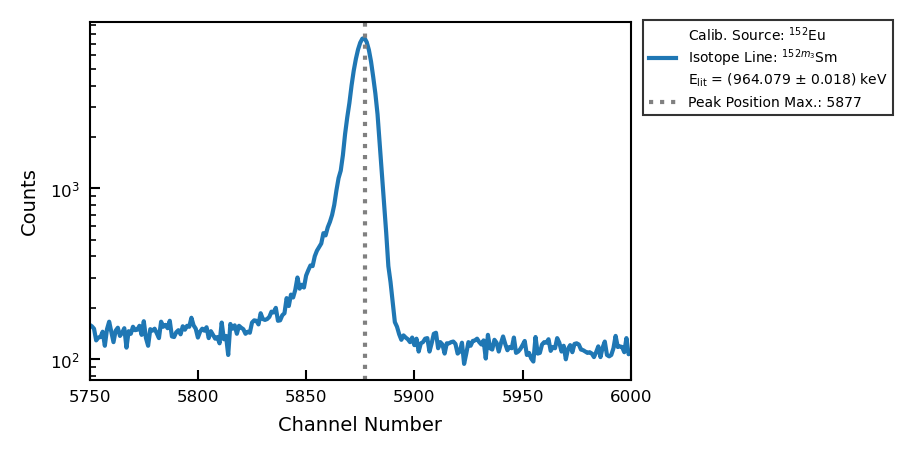

In [136]:
name = 'Sm763'
isotope = '$^{152m_3}$Sm'
e_lit = 964.079 #keV
e_err_lit = 0.018 #keV

#######################
## Adjust these values if necessary:
lower_channel = 5750
upper_channel = 6000
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [137]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = 0# (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.4, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 100]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-0.1,+0.1] #[-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [138]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 9.57403229e+04  5.87628584e+03  4.52588400e+00  1.22245606e+00
  2.81660091e+00  3.86889986e-01 -1.00000000e-01  7.13301063e+02]
Appending data for Sm763 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_3385/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


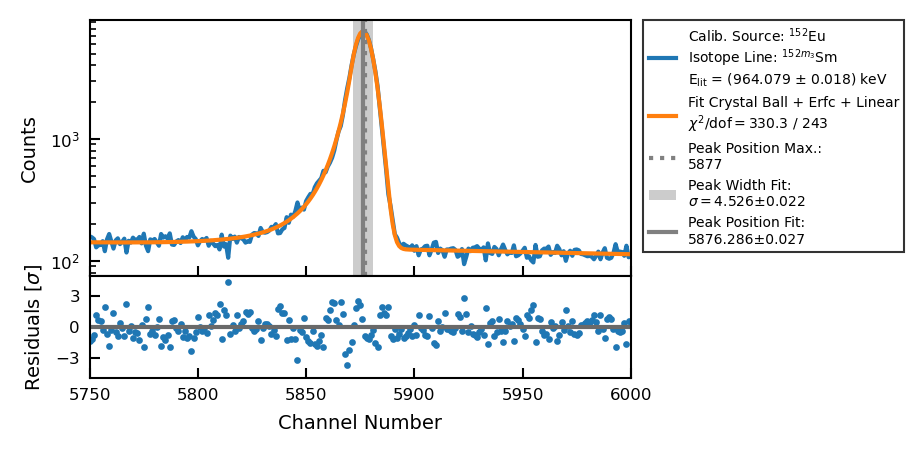

In [139]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Sm 1085

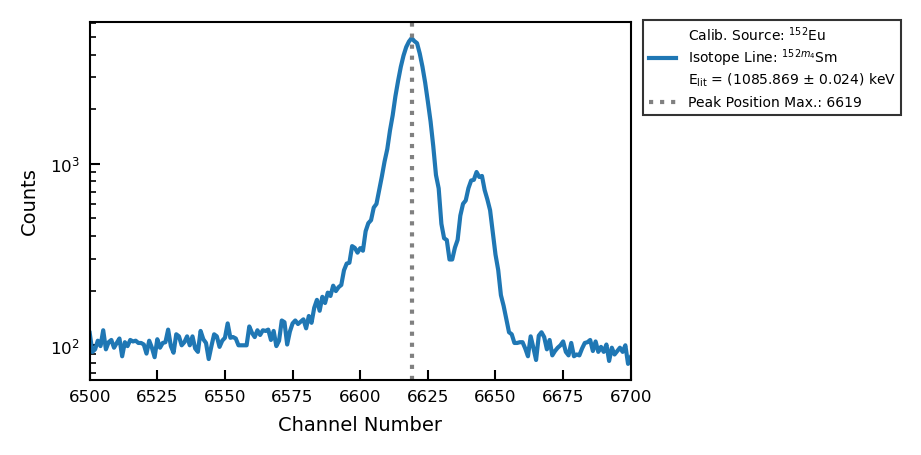

In [140]:
name = 'Sm1085'
isotope = '$^{152m_4}$Sm'
e_lit = 1085.869 #keV
e_err_lit = 0.024 #keV

#######################
## Adjust these values if necessary:
lower_channel = 6500
upper_channel = 6700
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [141]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 10. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.05, 100]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [142]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 6.47836360e+04  6.61894884e+03  4.90558975e+00  1.22923002e+00
  2.78716533e+00 -2.25000000e+01 -1.82243810e-01  1.33751467e+03]
Appending data for Sm1085 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_3385/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


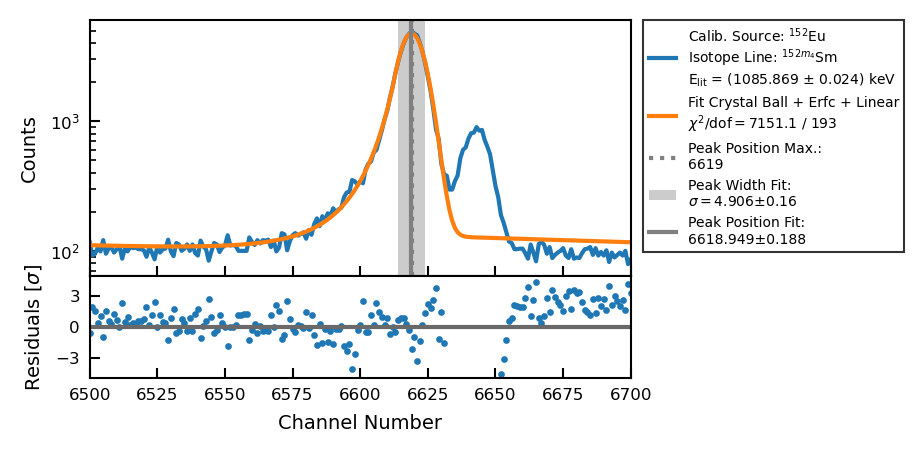

In [143]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

In [144]:
#little peak from Gd-152 at ~1089keV above Sm-152 peak affects the fit -> add additional Gaussian with clever fit constraints.

In [145]:
def fitFunc238(E, Gamma,P,sigma,alpha,n,S,m,q, Gamma2,P2,sigma2):
    res = Gamma* crystalball.pdf(E, alpha, n, P, sigma) + S * special.erfc((E-P)/(np.sqrt(2)*sigma)) + m*E+q + (Gamma2 * np.exp(-(E-P2)**2/(2*sigma2**2)))
    return res

In [146]:
guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,_,_,_ = popt
#guess_sigma = popt[2]

guess_P2 = popt[1] + 5*popt[2]
guess_Gamma2 = (val_max - high_med)/10
guess_sigma2 = popt[2]

limits_P2 = [popt[1] + 3*popt[2], min(popt[1]+7*popt[2], upper_channel)]
limits_Gamma2 = [1, (val_max - high_med)/2]
limits_sigma2 = [0.5, min(2*popt[2], 100,(upper_channel-lower_channel)/2)]

In [147]:
## Total Fit
popt, pcov = curve_fit(fitFunc238, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q,guess_Gamma2,guess_P2,guess_sigma2], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0],limits_Gamma2[0],limits_P2[0],limits_sigma2[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1],limits_Gamma2[1],limits_P2[1],limits_sigma2[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])
peak2_position = popt[9]
peak2_position_unc = np.sqrt(pcov[9,9])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc238(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

[ 6.69732475e+04  6.61893313e+03  4.84532832e+00  1.27240852e+00
  2.11967249e+00 -2.25000000e+01 -2.56531348e-01  1.80905368e+03
  7.69119388e+02  6.64264960e+03  4.76332688e+00]
Entry for Sm1085 already in df_calibration, will overwrite it!


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_3385/85123737.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


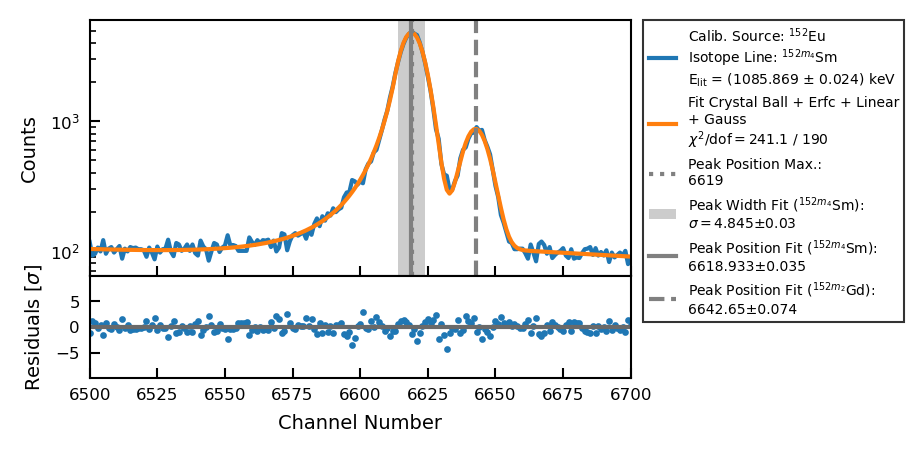

In [148]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc238(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n+ Gauss\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit ('+isotope+'): \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit ('+isotope+'):\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.axvline(peak2_position, linestyle='dashed', color = 'gray', 
            label='Peak Position Fit ($^{152m_2}$Gd):\n'+str(round(peak2_position,3))+'±'+str(round(peak2_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-10,10)
ax1.set_yticks(np.arange(-5, 5.1, step=5))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
plt.show()

## Sm 1112

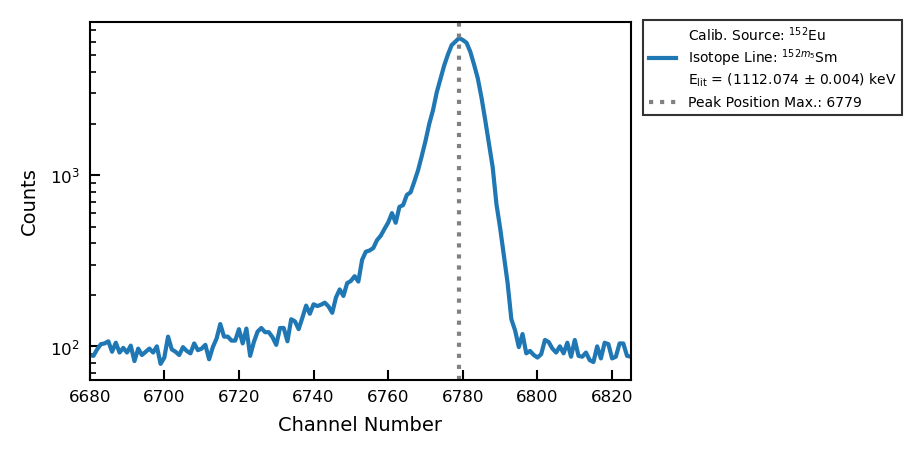

In [149]:
name = 'Sm1112'
isotope = '$^{152m_5}$Sm'
e_lit = 1112.074 #keV
e_err_lit = 0.004 #keV

#######################
## Adjust these values if necessary:
lower_channel = 6680
upper_channel = 6825
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [150]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 1. ##random guess, seems to work
guess_n = 50. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.01, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

In [151]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 8.76690827e+04  6.77898110e+03  4.68322742e+00  1.15093807e+00
  2.27626910e+00 -2.25000000e+01 -2.31741806e-01  1.67046686e+03]
Appending data for Sm1112 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_3385/606068960.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


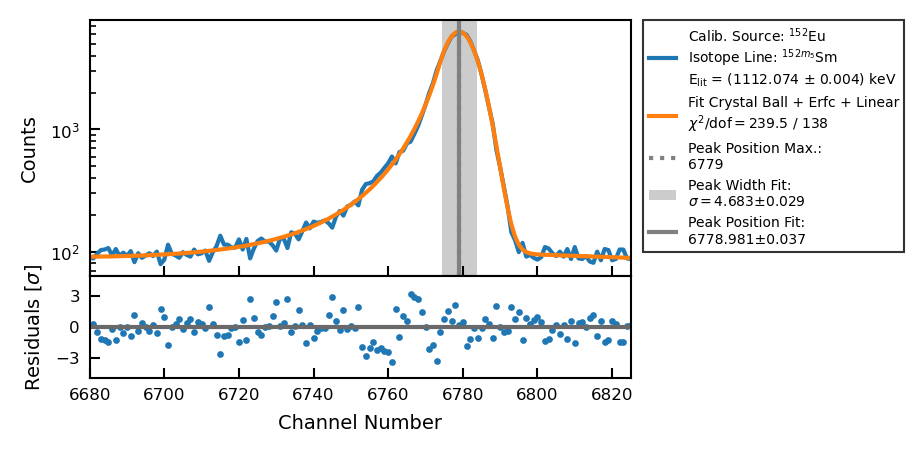

In [152]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

## Sm 1408

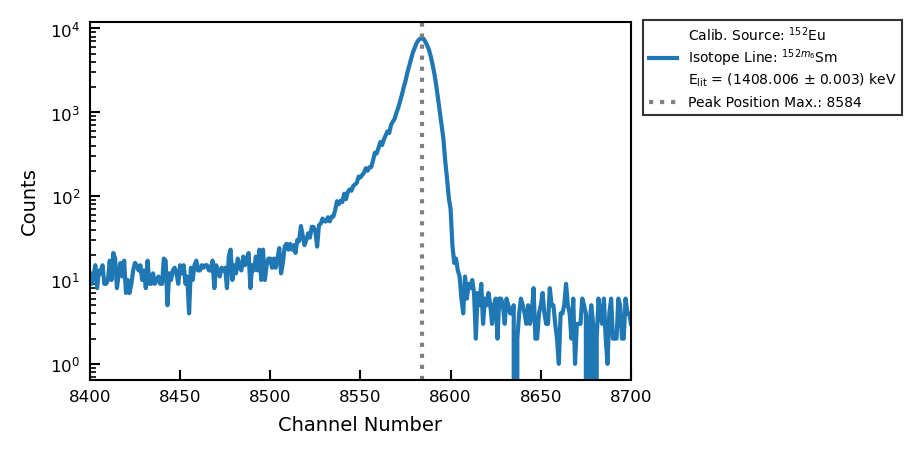

In [153]:
name = 'Sm1408'
isotope = '$^{152m_6}$Sm'
e_lit = 1408.006 #keV
e_err_lit = 0.003 #keV

#######################
## Adjust these values if necessary:
lower_channel = 8400
upper_channel = 8700
#######################

df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')

channel_max = df_sel_peak.loc[df_sel_peak['counts'].idxmax(), 'channel']
plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.: '+str(channel_max))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()

In [154]:
## Calculate helpful quantities
val_max = df_sel_peak['counts'].max()
val_min = df_sel_peak['counts'].min()
val_perc10 = np.percentile(df_sel_peak['counts'], 10)
val_perc50 = np.percentile(df_sel_peak['counts'], 50)
low_med = np.median(np.array(df_sel_peak.counts)[:int((upper_channel-lower_channel)/10)])
high_med = np.median(np.array(df_sel_peak.counts)[-int((upper_channel-lower_channel)/10):])

## Initial guesses fit
guess_P = channel_max
guess_Gamma = val_max - (low_med+high_med)/2
guess_sigma = min(np.sqrt(np.abs(np.sum((df_sel_peak.channel-channel_max)**2*(df_sel_peak.counts-(low_med+high_med)/2))/np.sum(df_sel_peak.counts-(low_med+high_med)/2))), (upper_channel-lower_channel)/4)
guess_alpha = 10. ##random guess, seems to work
guess_n = 20. ##random guess, seems to work
guess_S = np.abs(low_med-high_med)/2 ## default erfc has max-min=2; abs as usually step down
guess_m = (high_med-low_med)/(upper_channel-lower_channel)
guess_q = low_med - lower_channel * (high_med-low_med)/(upper_channel-lower_channel)

## Boundaries fit
limits_P = [lower_channel, upper_channel]
limits_Gamma = [0, +np.inf]
limits_sigma = [0.5, min(100,(upper_channel-lower_channel)/2)]
limits_alpha = [0.01, 1000]
limits_n = [0.05, 1000]
limits_S = [-5*guess_S,5*guess_S]
limits_m = [-np.inf,+np.inf]
limits_q = [-np.inf,+np.inf]

'''## Improve guess/limits parameter sigma from Gauss+Step fit
try:
    popt, pcov = curve_fit(gausStepFunc, df_sel_peak.channel, df_sel_peak.counts, 
                           p0=[guess_Gamma, guess_S, guess_P, guess_sigma, (low_med+high_med)/2], 
                           bounds=((limits_Gamma[0], limits_S[0], limits_P[0], limits_sigma[0], 1.1*val_min-0.1*val_max),
                                   (limits_Gamma[1], limits_S[1], limits_P[1], limits_sigma[1], val_max)), 
                           sigma=df_sel_peak.counts_err, maxfev=10000)
    _,_,_,guess_sigma,_ = popt
    limits_sigma[1] = min(5*guess_sigma, limits_sigma[1])
except:
    print('Warning: gausStepFunc failed!')''';

In [155]:
'''df_sel_peak = df.copy()[(df.channel>=lower_channel) & (df.channel<=upper_channel)]
df_sel_peak['counts_err'] = np.maximum(np.sqrt(df_sel_peak.counts),np.ones(len(df_sel_peak)))
plt.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{228}$Th\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
plt.plot(df_sel_peak.channel, gausStepFunc(df_sel_peak.channel, *popt), 
         label='Fit Gauss + Erfc')

plt.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
plt.axvspan(popt[2]-popt[3], popt[2]+popt[3], alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(popt[3],3))+'±'+str(round(np.sqrt(pcov[3,3]),3)))
plt.axvline(popt[2], linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(popt[2],3))+'±'+str(round(np.sqrt(pcov[2,2]),3)))

plt.yscale('log')
plt.xlim(lower_channel, upper_channel)
plt.xlabel('Channel Number')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
plt.show()''';

In [156]:
## Total Fit

#popt, pcov = curve_fit(crystalballFunc, df_sel_peak.channel, df_sel_peak.counts, 
#                       p0=[guess_Gamma, guess_P, guess_sigma, 1, 10, (low_med+high_med)/2], 
#                       bounds=((limits_Gamma[0], limits_P[0], limits_sigma[0],limits_alpha[0],limits_n[0], 1.1*val_min-0.1*val_max),
#                               (limits_Gamma[1], limits_P[1], limits_sigma[1],limits_alpha[1],limits_n[1], val_max)), 
#                       sigma=df_sel_peak.counts_err, maxfev=10000)
#fitFunc(E, Gamma,P,sigma,alpha,n,S,m,q)
popt, pcov = curve_fit(fitFunc, df_sel_peak.channel, df_sel_peak.counts, 
                       p0=[guess_Gamma,guess_P,guess_sigma,guess_alpha,guess_n,guess_S,guess_m,guess_q], 
                       bounds=((limits_Gamma[0],limits_P[0],limits_sigma[0],limits_alpha[0],limits_n[0],limits_S[0],limits_m[0],limits_q[0]),
                               (limits_Gamma[1],limits_P[1],limits_sigma[1],limits_alpha[1],limits_n[1],limits_S[1],limits_m[1],limits_q[1])), 
                       sigma=df_sel_peak.counts_err, maxfev=10000)
print(popt)

peak_position = popt[1]
peak_position_unc = np.sqrt(pcov[1,1])
peak_width = popt[2]
peak_width_unc = np.sqrt(pcov[2,2])

if np.abs(peak_position-channel_max) > peak_width:
    print('Warning: Peak maximum position and fitted peak position deviate by more than the fittet peak width!')
'''if np.abs(peak_width-guess_sigma)/peak_width > 0.2:
    print('Warning: Final peak width deviates from gausStepFunc peak width by '+str(round(100*np.abs(peak_width-guess_sigma)/peak_width,1))+' %')'''
    
chi2 = np.sum((fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts)**2 / (df_sel_peak.counts_err)**2)
dof = len(df_sel_peak)-len(popt)
df_sel_peak['residuals'] = (fitFunc(df_sel_peak.channel, *popt) - df_sel_peak.counts) / (df_sel_peak.counts_err)

if name not in df_calibration.name.tolist():
    print('Appending data for '+name+' to df_calibration.')
else:
    print('Entry for '+name+' already in df_calibration, will overwrite it!')
    df_calibration = df_calibration[df_calibration.name != name]
df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit], 
                                'peak_position': [peak_position], 'peak_position_unc': [peak_position_unc], 
                                'peak_width': [peak_width], 'peak_width_unc': [peak_width_unc], 
                                'chi2_dof': [chi2/dof], 'channel_max': [channel_max]}), ignore_index=True)

/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/Users/aravindremesansreekala/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:9618: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


[ 1.14688105e+05  8.58370263e+03  5.17182011e+00  1.12257594e+00
  2.96477604e+00 -2.50957163e+00 -4.09869935e-02  3.58033893e+02]
Appending data for Sm1408 to df_calibration.


/var/folders/f4/949b_j_s5xsdh37vbkg_3j2r0000gn/T/ipykernel_3385/2228432332.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_calibration = df_calibration.append(pd.DataFrame(data={'name': [name], 'e_lit': [e_lit], 'e_err_lit': [e_err_lit],


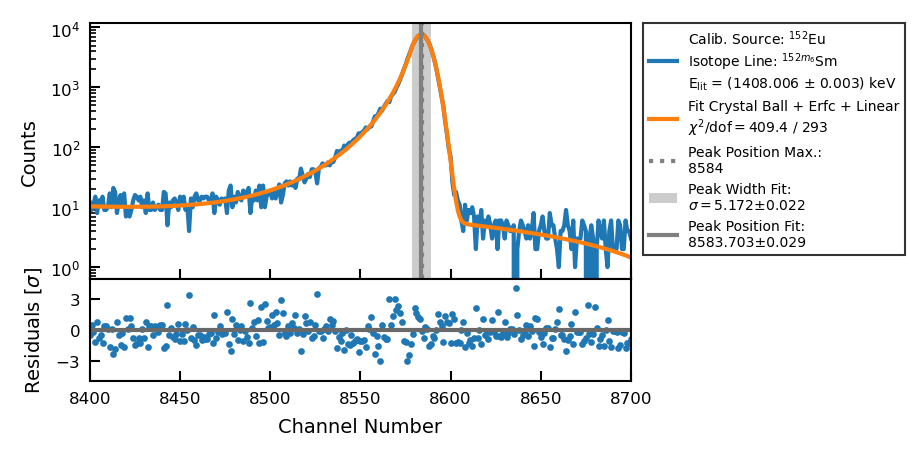

In [157]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")
ax0.plot(df_sel_peak.channel, df_sel_peak.counts, 
        label = 'Calib. Source: $^{152}$Eu\nIsotope Line: '+isotope+'\nE$_{\mathrm{lit}}$ = ('+str(e_lit)+' ± '+str(e_err_lit)+') keV')
ax0.plot(df_sel_peak.channel, fitFunc(df_sel_peak.channel, *popt), 
         label='Fit Crystal Ball + Erfc + Linear\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.axvline(x=channel_max, linestyle='dotted', color = 'gray', label='Peak Position Max.:\n'+str(channel_max))
ax0.axvspan(peak_position-peak_width, peak_position+peak_width, alpha=0.4, facecolor='gray', zorder = 0, 
            label = 'Peak Width Fit: \n$\sigma = $'+str(round(peak_width,3))+'±'+str(round(peak_width_unc,3)))
ax0.axvline(peak_position, linestyle='-', color = 'gray', 
            label='Peak Position Fit:\n'+str(round(peak_position,3))+'±'+str(round(peak_position_unc,3)))
ax0.set_ylabel('Counts')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.scatter(df_sel_peak.channel, df_sel_peak.residuals,s=2)
ax1.axhline(y=0, color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [$\sigma$]')
ax1.set_ylim(-5,5)
ax1.set_yticks(np.arange(-3, 3.1, step=3))
plt.xlim(lower_channel, upper_channel)

legend = ax0.legend(loc=2, bbox_to_anchor=(1.01,1.025), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_line_fit_'+name+'.png', bbox_inches='tight')
plt.show()

# Quality Checks

In [158]:
df_calibration

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max
0,Sm121,121.7817,0.0003,739.298120,0.016317,2.832401,0.014582,3.668584,739.0
1,Sm244,244.6974,0.0008,1489.228772,0.017237,3.089143,0.015242,1.274340,1489.0
2,Gd344,344.2785,0.0012,2096.608284,0.011595,3.351679,0.009783,1.948236,2097.0
3,Gd778,778.9040,0.0018,4747.202090,0.030784,4.185116,0.026034,1.832222,4748.0
4,Sm867,867.3780,0.0040,5286.734500,0.053336,4.332106,0.046645,1.247026,5288.0
5,Sm763,964.0790,0.0180,5876.285844,0.026660,4.525884,0.022304,1.359131,5877.0
6,Sm1085,1085.8690,0.0240,6618.933129,0.034966,4.845328,0.029661,1.268947,6619.0
7,Sm1112,1112.0740,0.0040,6778.981100,0.037384,4.683227,0.029372,1.735772,6779.0
8,Sm1408,1408.0060,0.0030,8583.702634,0.028784,5.171820,0.022225,1.397168,8584.0


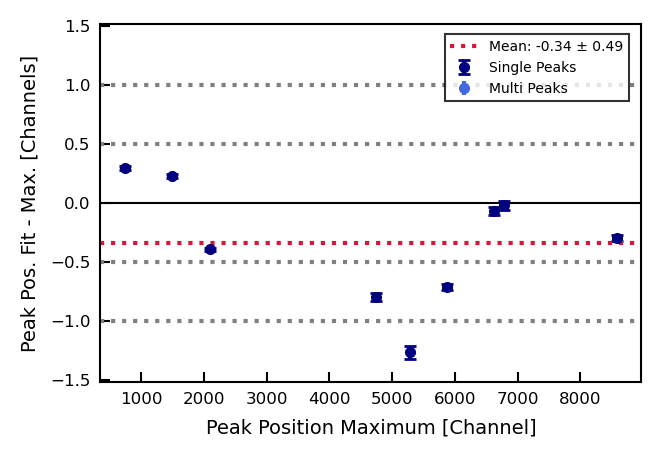

     name      e_lit  e_err_lit  peak_position  peak_position_unc  peak_width  \
0   Sm121   121.7817     0.0003     739.298120           0.016317    2.832401   
1   Sm244   244.6974     0.0008    1489.228772           0.017237    3.089143   
2   Gd344   344.2785     0.0012    2096.608284           0.011595    3.351679   
3   Gd778   778.9040     0.0018    4747.202090           0.030784    4.185116   
4   Sm867   867.3780     0.0040    5286.734500           0.053336    4.332106   
5   Sm763   964.0790     0.0180    5876.285844           0.026660    4.525884   
6  Sm1085  1085.8690     0.0240    6618.933129           0.034966    4.845328   
7  Sm1112  1112.0740     0.0040    6778.981100           0.037384    4.683227   
8  Sm1408  1408.0060     0.0030    8583.702634           0.028784    5.171820   

   peak_width_unc  chi2_dof  channel_max  
0        0.014582  3.668584        739.0  
1        0.015242  1.274340       1489.0  
2        0.009783  1.948236       2097.0  
3        0.026034

In [159]:
plt.errorbar(df_calibration.channel_max, df_calibration.peak_position-df_calibration.channel_max, 
             yerr = df_calibration.peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'navy', label = 'Single Peaks')
try:
    plt.errorbar(df_calibration[df_calibration.name == 'Bi727'].channel_max, 
                 df_calibration[df_calibration.name == 'Bi727'].peak_position-df_calibration[df_calibration.name == 'Bi727'].channel_max, 
                 yerr = df_calibration[df_calibration.name == 'Bi727'].peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'royalblue', 
                 label = 'Multi Peaks')
except:
    pass
try:
    plt.errorbar(df_calibration[df_calibration.name == 'Pb238'].channel_max, 
                 df_calibration[df_calibration.name == 'Pb238'].peak_position-df_calibration[df_calibration.name == 'Pb238'].channel_max, 
                 yerr = df_calibration[df_calibration.name == 'Pb238'].peak_position_unc, fmt = 'o', ms=3, capsize=2, color = 'royalblue', )
except:
    pass
plt.axhline(y=0, linestyle='-', color = 'k', linewidth = 0.75)
plt.axhline(y=+0.5, linestyle='dotted', color = 'gray')
plt.axhline(y=-0.5, linestyle='dotted', color = 'gray')
plt.axhline(y=+1.0, linestyle='dotted', color = 'gray')
plt.axhline(y=-1.0, linestyle='dotted', color = 'gray')
val_mean_diff = np.mean(df_calibration.peak_position-df_calibration.channel_max)
val_std_diff = np.std(df_calibration.peak_position-df_calibration.channel_max)
plt.axhline(y=val_mean_diff, 
            linestyle='dotted', color = 'crimson', label = 'Mean: '+str(round(val_mean_diff,2))+' ± '+str(round(val_std_diff,2)))
plt.xlabel('Peak Position Maximum [Channel]')
plt.ylabel('Peak Pos. Fit - Max. [Channels]')
val_lim = 1.2*np.max(np.abs(df_calibration.peak_position-df_calibration.channel_max))
plt.ylim(-val_lim, +val_lim)

legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

if save_plots:
    plt.savefig(filename_suffix_save+'_deviation_lines_max_fit.png', bbox_inches='tight')
plt.show()
print(df_calibration)

In [160]:
thr = 5
outlier_check = np.abs(df_calibration.peak_position-df_calibration.channel_max)>thr
if np.any(outlier_check):
    print('Warning: For the following peaks, the peak max. and fit positions differ by more than 1 Channel and are hence removed from the following analysis: '+str(df_calibration[outlier_check].name.tolist()))
    #df_calibration = df_calibration.drop(df_calibration[outlier_check].index.values)
else:
    print('For all peaks, the peak max. and fit positions differ by less than '+str(thr)+' Channel. We hence keep them all for the following analysis.')
    print(df_calibration)

For all peaks, the peak max. and fit positions differ by less than 5 Channel. We hence keep them all for the following analysis.
     name      e_lit  e_err_lit  peak_position  peak_position_unc  peak_width  \
0   Sm121   121.7817     0.0003     739.298120           0.016317    2.832401   
1   Sm244   244.6974     0.0008    1489.228772           0.017237    3.089143   
2   Gd344   344.2785     0.0012    2096.608284           0.011595    3.351679   
3   Gd778   778.9040     0.0018    4747.202090           0.030784    4.185116   
4   Sm867   867.3780     0.0040    5286.734500           0.053336    4.332106   
5   Sm763   964.0790     0.0180    5876.285844           0.026660    4.525884   
6  Sm1085  1085.8690     0.0240    6618.933129           0.034966    4.845328   
7  Sm1112  1112.0740     0.0040    6778.981100           0.037384    4.683227   
8  Sm1408  1408.0060     0.0030    8583.702634           0.028784    5.171820   

   peak_width_unc  chi2_dof  channel_max  
0        0.014582

# Calibration

## Linear fit

In [161]:
popt, pcov = curve_fit(linFunc, df_calibration.peak_position, df_calibration.e_lit, 
                       p0=[np.median(df_calibration.e_lit/df_calibration.peak_position), 0], 
                       bounds=((0, -np.inf),
                               (+np.inf, +np.inf)), 
                       sigma=df_calibration.peak_width, maxfev=10000)
cal_CE_a = popt[0]
print(cal_CE_a)
cal_CE_a_err = np.sqrt(pcov[0, 0])
print(cal_CE_a_err)
cal_CE_b = popt[1]
print('')
print(cal_CE_b)
cal_CE_b_err = np.sqrt(pcov[1, 1])
print(cal_CE_b_err)
cal_CE_cov_ab = pcov[0, 1]
cal_CE = (cal_CE_a, cal_CE_b)

cal_EC_a = 1/cal_CE_a
cal_EC_b = -cal_CE_b/cal_CE_a
cal_EC = (cal_EC_a, cal_EC_b)

with open(filename_suffix_save+'_calibration_parameters.txt', 'w') as writer:
    writer.write("cal_CE_a"+"\n")
    writer.write(str(cal_CE_a)+"\n")
    writer.write("cal_CE_a_err"+"\n")
    writer.write(str(cal_CE_a_err)+"\n")
    writer.write("cal_CE_b"+"\n")
    writer.write(str(cal_CE_b)+"\n")
    writer.write("cal_CE_b_err"+"\n")
    writer.write(str(cal_CE_b_err)+"\n")
    writer.write("cal_CE_cov_ab"+"\n")
    writer.write(str(cal_CE_cov_ab)+"\n")
    
df_calibration
df_calibration.to_csv('Eu152_calib.txt', sep = ',')

0.16397043345144954
3.55996149822649e-06

0.525435801458153
0.01579137520066022


In [58]:
reconstr_e = linFunc(df_calibration.peak_position, *cal_CE)
df_calibration['reconstr_e'] = reconstr_e
reconstr_e_err = np.sqrt(cal_CE_b_err**2 + (cal_CE_a_err*df_calibration.peak_position)**2 + 2*(df_calibration.peak_position)*cal_CE_cov_ab)
residuals_e = reconstr_e - df_calibration.e_lit
residuals_e_err = np.sqrt(reconstr_e_err**2 + (df_calibration.e_err_lit)**2)
print(np.mean(residuals_e))

-0.0003416141308921144


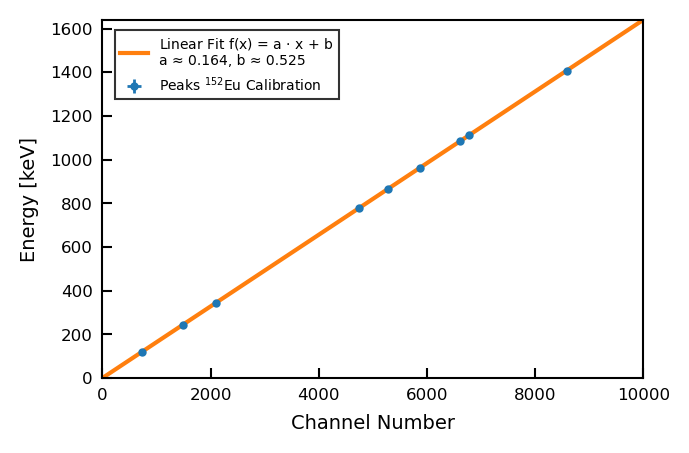

In [59]:
plt.errorbar(df_calibration.peak_position, df_calibration.e_lit, 
             xerr = df_calibration.peak_width, yerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks $^{152}$Eu Calibration', linewidth=1)
plt.plot(np.linspace(0,16383,10), linFunc(np.linspace(0,16383,10), *popt), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(popt[0],3))+', b ≈ '+str(round(popt[1],3)))
plt.xlabel('Channel Number')
plt.ylabel('Energy [keV]')
#plt.xscale('log'); plt.yscale('log');
plt.xlim(0, 10000)
plt.ylim(0, linFunc(10000, *popt))
legend = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit.png', bbox_inches='tight')
plt.show()

In [60]:
chi2 = np.sum(residuals_e**2 / residuals_e_err**2)
dof = len(residuals_e)-len(popt)

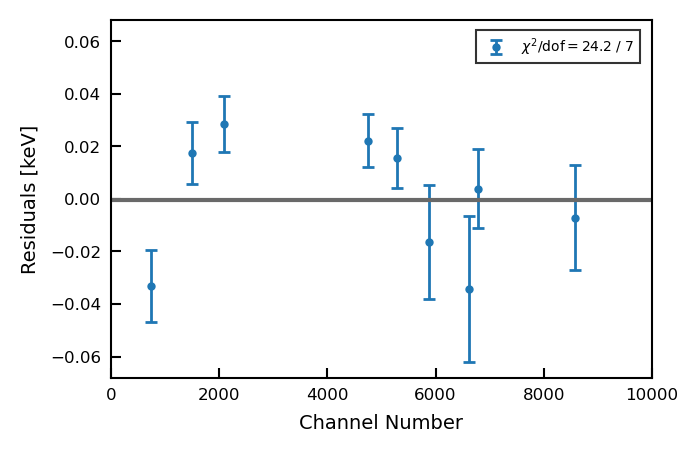

In [61]:
plt.errorbar(df_calibration.peak_position, residuals_e, yerr = residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.axhline(y=np.mean(residuals_e), color = 'dimgray')
plt.xlabel('Channel Number')
plt.ylabel('Residuals [keV]')
val_lim = max(np.abs(1.1*np.max(residuals_e+residuals_e_err)), np.abs(1.1*np.min(residuals_e-residuals_e_err)))
plt.xlim(0, 10000)
plt.ylim(-val_lim, val_lim)
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_residuals.png', bbox_inches='tight')
plt.show()

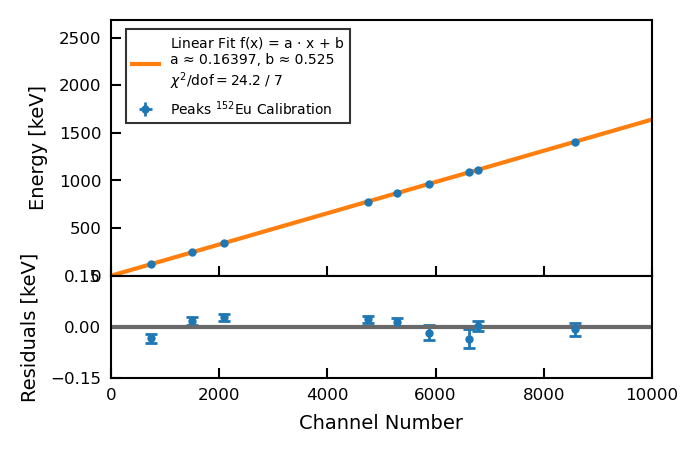

In [62]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.peak_position, df_calibration.e_lit, 
             xerr = df_calibration.peak_width, yerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks $^{152}$Eu Calibration', linewidth=1)
ax0.plot(np.linspace(0,16383,10), linFunc(np.linspace(0,16383,10), *popt), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(popt[0],6))+', b ≈ '+str(round(popt[1],3))+
         '\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy [keV]')
ax0.set_ylim(0, linFunc(16383, *popt))

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.peak_position, residuals_e, yerr = residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals_e), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Residuals [keV]')
val_lim = max(np.abs(1.1*np.max(residuals_e+residuals_e_err)), np.abs(1.1*np.min(residuals_e-residuals_e_err)))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
plt.xlim(0, 10000)

legend = ax0.legend(loc=2, bbox_to_anchor=(0.015,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_residuals.png', bbox_inches='tight')
plt.show()

In [63]:
print('MCA_ch Residual MCA_ch_error Residual_error')
out = np.array([np.array(df_calibration.peak_position), np.array(residuals_e), 
                np.array(df_calibration.peak_width), np.array(residuals_e_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Residual MCA_ch_error Residual_error
739.2981195005566 -0.03323109419403636 2.832400511792867 0.013728311246810619
1489.2287715785033 0.017522985555075365 3.0891430560456534 0.01188705862457514
2096.608283802872 0.028704874514801304 3.351679244576803 0.010672653732916487
4747.20208970753 0.022220132428856232 4.185116083495722 0.010104319050574446
5286.734500343066 0.015583365443148978 4.332106089532494 0.011571530106955311
5876.285844374283 -0.016427211873406122 4.525884001642418 0.02170587089536526
6618.933129066852 -0.03423003929083279 4.845328318757701 0.027794280613934814
6778.981100156106 0.00390515323897489 4.683227421929863 0.014999809752005286
8583.702633940307 -0.007122693000610525 5.171820109974334 0.02008907513402495


In [64]:
print('Energy Residual Energy_error Residual_error')
out = np.array([np.array(df_calibration.e_lit), np.array(-cal_EC_a*residuals_e), 
                np.array(df_calibration.e_err_lit), np.array(cal_EC_a*residuals_e_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

Energy Residual Energy_error Residual_error
121.7817 0.20266516038622198 0.0003 0.08372430905889794
244.6974 -0.10686673924213169 0.0008 0.07249513448468631
344.2785 -0.17506128337033766 0.0012 0.06508889138282715
778.904 -0.13551304318187005 0.0018 0.061622811124459595
867.378 -0.09503765474745238 0.004 0.07057083318854285
964.079 0.10018398761060847 0.018 0.1323767366986452
1085.869 0.20875738735525182 0.024 0.16950788034700476
1112.074 -0.023816203670225567 0.004 0.09147874672446127
1408.006 0.043438886210662504 0.003 0.12251644830818342


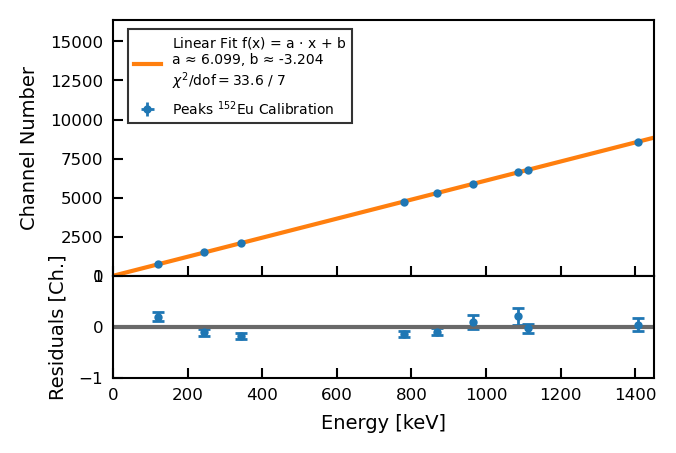

0     121.7817
1     244.6974
2     344.2785
3     778.9040
4     867.3780
5     964.0790
6    1085.8690
7    1112.0740
8    1408.0060
Name: e_lit, dtype: float64


0     739.298120
1    1489.228772
2    2096.608284
3    4747.202090
4    5286.734500
5    5876.285844
6    6618.933129
7    6778.981100
8    8583.702634
Name: peak_position, dtype: float64

In [104]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, df_calibration.peak_position, 
             yerr = df_calibration.peak_width, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 2, label = 'Peaks $^{152}$Eu Calibration', linewidth=1)
ax0.plot(np.linspace(0,2700,10), linFunc(np.linspace(0,2700,10), *cal_EC), 
         label = 'Linear Fit f(x) = a $\cdot$ x + b\na ≈ '+str(round(cal_EC[0],3))+', b ≈ '+str(round(cal_EC[1],3))+
         '\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Channel Number')
ax0.set_ylim(0, 16383)

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, -cal_EC_a*residuals_e, yerr = cal_EC_a*residuals_e_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(-cal_EC_a*residuals_e), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Residuals [Ch.]')
val_lim = max(np.abs(1.1*np.max(cal_EC_a*(residuals_e+residuals_e_err))), np.abs(1.1*np.min(cal_EC_a*(residuals_e-residuals_e_err))))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_yticks(np.arange(-1, 1.1, step=1))
plt.xlim(0, 1450)

legend = ax0.legend(loc=2, bbox_to_anchor=(0.015,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_calibration_fit_inverse_residuals.png', bbox_inches='tight')
plt.show()
#df_calibration
print(df_calibration.e_lit)
df_calibration.peak_position

## Spectrum

In [66]:
isotope_list = []
for i in df_calibration['name']:
    #print(i.find('Sm'))
    if i.find('Sm') == 0:
        isotope_list.append('$^{152}$Sm')
    elif i.find('Gd') == 0:
        isotope_list.append('$^{152}$Gd')
df_calibration['isotope'] = isotope_list

In [67]:
df_calibration

,name,e_lit,e_err_lit,peak_position,peak_position_unc,peak_width,peak_width_unc,chi2_dof,channel_max,reconstr_e,isotope
0,Sm121,121.7817,0.0003,739.298120,0.016317,2.832401,0.014582,3.668584,739.0,121.748469,$^{152}$Sm
1,Sm244,244.6974,0.0008,1489.228772,0.017237,3.089143,0.015242,1.274340,1489.0,244.714923,$^{152}$Sm
2,Gd344,344.2785,0.0012,2096.608284,0.011595,3.351679,0.009783,1.948236,2097.0,344.307205,$^{152}$Gd
3,Gd778,778.9040,0.0018,4747.202090,0.030784,4.185116,0.026034,1.832222,4748.0,778.926220,$^{152}$Gd
4,Sm867,867.3780,0.0040,5286.734500,0.053336,4.332106,0.046645,1.247026,5288.0,867.393583,$^{152}$Sm
5,Sm763,964.0790,0.0180,5876.285844,0.026660,4.525884,0.022304,1.359131,5877.0,964.062573,$^{152}$Sm
6,Sm1085,1085.8690,0.0240,6618.933129,0.034966,4.845328,0.029661,1.268947,6619.0,1085.834770,$^{152}$Sm
7,Sm1112,1112.0740,0.0040,6778.981100,0.037384,4.683227,0.029372,1.735772,6779.0,1112.077905,$^{152}$Sm
8,Sm1408,1408.0060,0.0030,8583.702634,0.028784,5.171820,0.022225,1.397168,8584.0,1407.998877,$^{152}$Sm


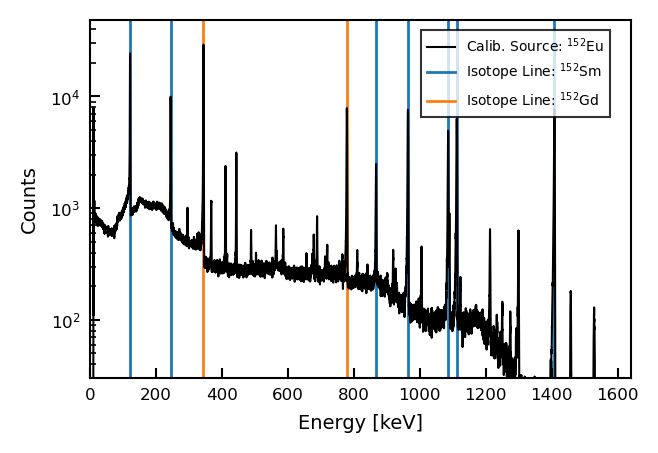

In [68]:
plt.plot(linFunc(df.channel, *cal_CE), df.counts, color = 'black', linewidth = 0.75, label = 'Calib. Source: $^{152}$Eu')
for i, line in enumerate(df_calibration[df_calibration['isotope'] == '$^{152}$Sm'].e_lit):
    if i == 0:
        plt.axvline(x = line, color = 'C0', label = 'Isotope Line: $^{152}$Sm', zorder = 0, linewidth = 1)
    else:
        plt.axvline(x = line, color = 'C0', zorder = 0, linewidth = 1)
for i, line in enumerate(df_calibration[df_calibration['isotope'] == '$^{152}$Gd'].e_lit):
    if i == 0:
        plt.axvline(x = line, color = 'C1', label = 'Isotope Line: $^{152}$Gd', zorder = 0, linewidth = 1)
    else:
        plt.axvline(x = line, color = 'C1', zorder = 0, linewidth = 1)
plt.yscale('log')
plt.xlim(0,linFunc(10000, *cal_CE))
plt.ylim(bottom = 30)
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
legend = plt.legend(loc=2, bbox_to_anchor=(0.6,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_spectrum_lines_marked.png', bbox_inches='tight')
plt.show()

# Resolution

In [69]:
ratio_width_fitlit = cal_CE_a*df_calibration.peak_width/df_calibration.e_err_lit
ratio_width_fitlit

0    1548.099799
1     633.160157
2     457.980249
3     381.241832
4     177.584328
5      41.228398
6      33.103774
7     191.977708
8     282.675195
dtype: float64

In [70]:
df_calibration.peak_width

0    2.832401
1    3.089143
2    3.351679
3    4.185116
4    4.332106
5    4.525884
6    4.845328
7    4.683227
8    5.171820
Name: peak_width, dtype: float64

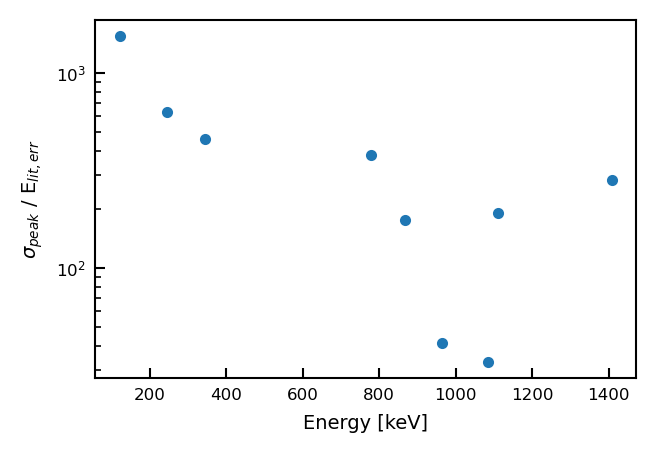

In [71]:
plt.errorbar(df_calibration.e_lit, ratio_width_fitlit, 
            fmt = 'o', ms = 3)
#plt.axhline(y = 20, color = 'gray')
plt.yscale('log')
plt.xlabel('Energy [keV]')
plt.ylabel('$\sigma_{peak}$ / E$_{lit, err}$')
plt.show()

In [72]:
## Remove lines where ratio_width_fitlit<20
#reconstr_e = reconstr_e[ratio_width_fitlit>20]
#reconstr_e_err = reconstr_e_err[ratio_width_fitlit>20]

In [73]:
rel_resol = cal_CE_a*df_calibration.peak_width / reconstr_e
rel_resol_err = rel_resol*np.sqrt((reconstr_e_err/reconstr_e)**2+(cal_CE_a_err/cal_CE_a)**2+(df_calibration.peak_width_unc/df_calibration.peak_width)**2)

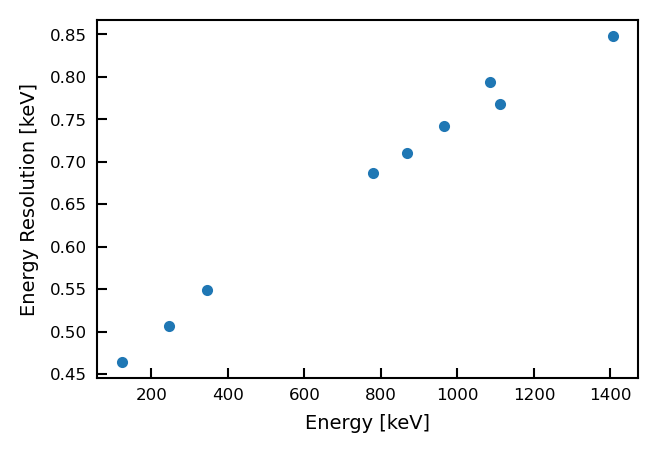

In [74]:
plt.errorbar(df_calibration.e_lit, rel_resol*reconstr_e, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3)
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [keV]')
plt.show()

In [75]:
def relresolFunc(E, a,b,c):
    relresol = np.sqrt(a/E**2 + b/E + c)
    return relresol

In [76]:
popt_relresol, pcov_relresol = curve_fit(relresolFunc, df_calibration.e_lit, rel_resol, 
                       p0=[0.1, 0.1, 0.1], 
                       bounds=((0, 0, 0),
                               (+np.inf, +np.inf, +np.inf)), 
                       sigma=rel_resol_err, maxfev=10000)
print(popt_relresol[0])
print(popt_relresol[1])
print(popt_relresol[2])
print(np.sqrt(np.diag(pcov_relresol)))
reconstr_relresol = relresolFunc(df_calibration.e_lit, *popt_relresol)
residuals = reconstr_relresol - rel_resol
reconstr_relresol_err = 1/2*np.sqrt(popt_relresol[0]**2/df_calibration.e_lit**4 + popt_relresol[1]**2/df_calibration.e_lit**2 + popt_relresol[2]**2)
residuals_err = np.sqrt(reconstr_relresol_err**2 + rel_resol_err**2)
chi2 = np.sum(residuals**2 / residuals_err**2)
dof = len(residuals)-len(popt)

0.16485593721380015
0.00039627425097010294
1.1836498098783399e-09
[7.74522847e-03 3.39524372e-05 2.47878063e-08]


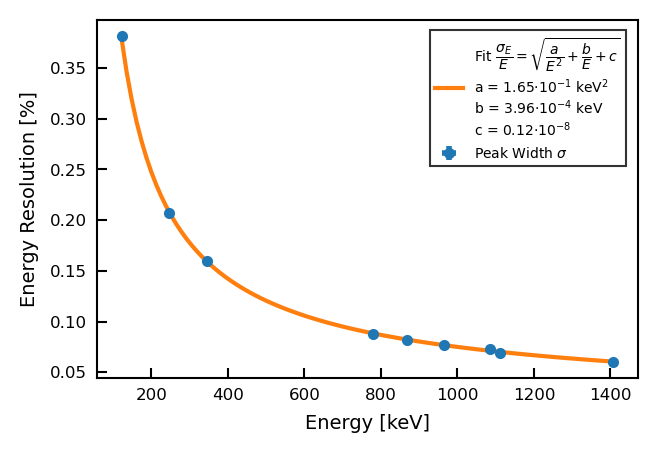

In [77]:
plt.errorbar(df_calibration.e_lit, 100*rel_resol, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol), label = 'Fit $\dfrac{\sigma_E}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(1e1*popt_relresol[0],2))+'$\cdot 10^{-1}$ keV$^2$' 
         +'\nb = '+str(round(1e4*popt_relresol[1],2))+'$\cdot 10^{-4}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$')
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit.png', bbox_inches='tight')
plt.show()

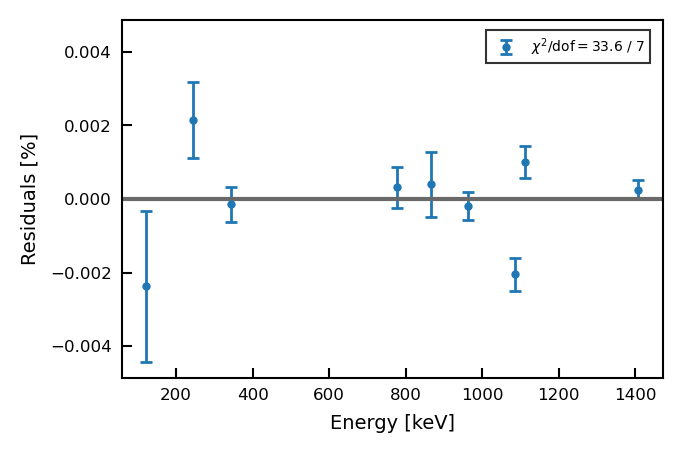

In [78]:
plt.errorbar(df_calibration.e_lit, 100*residuals, yerr = 100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.axhline(y=np.mean(residuals), color = 'dimgray')
plt.xlabel('Energy [keV]')
plt.ylabel('Residuals [%]')
val_lim = max(np.abs(100*1.1*np.max(residuals+residuals_err)), np.abs(100*1.1*np.min(residuals-residuals_err)))
plt.ylim(-val_lim, val_lim)
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals.png', bbox_inches='tight')
plt.show()

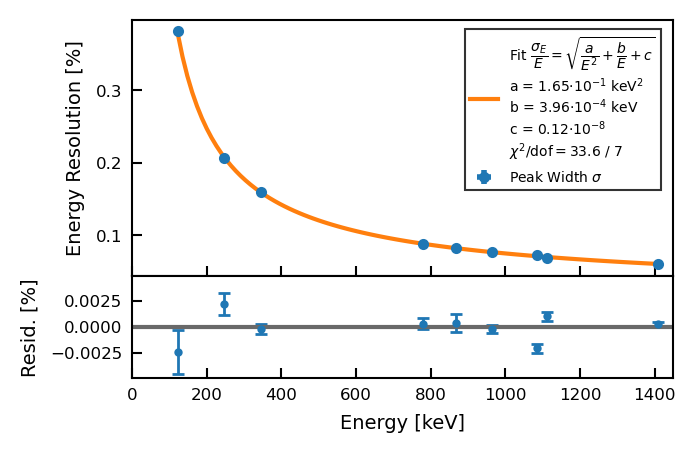

In [79]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, 100*rel_resol, yerr = rel_resol_err, xerr = df_calibration.e_err_lit,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol), label = 'Fit $\dfrac{\sigma_E}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(1e1*popt_relresol[0],2))+'$\cdot 10^{-1}$ keV$^2$' 
         +'\nb = '+str(round(1e4*popt_relresol[1],2))+'$\cdot 10^{-4}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, 100*residuals, yerr = 100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(100*1.1*np.max(residuals+residuals_err)), np.abs(100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
plt.xlim(0, 1450)

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals.png', bbox_inches='tight')
plt.show()

### as function of MCA

In [80]:
resol = df_calibration.peak_width
resol_err = df_calibration.peak_width_unc

In [81]:
def resolFunc(E, a,b,c):
    resol = np.sqrt(a*(E**2) + b*E + c)
    return resol

In [82]:
popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2

(1.1836498098783399e-09, 0.0024167421078839612, 6.1315955908916)

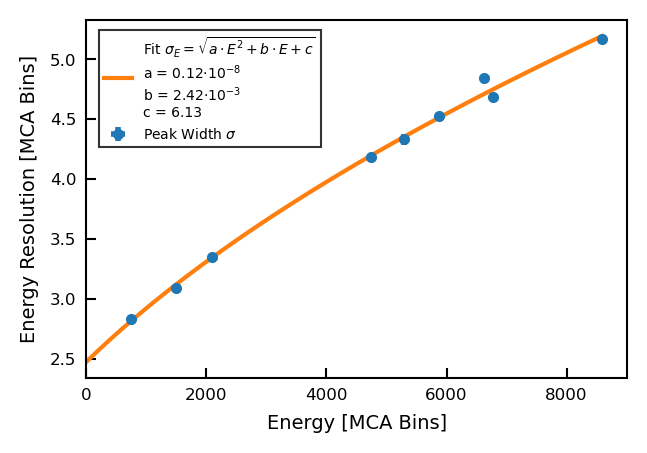

In [83]:
plt.errorbar(df_calibration.peak_position, resol, yerr = resol_err, xerr = df_calibration.peak_position_unc,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = np.linspace(0, np.array(df_calibration.peak_position)[-1], 100)
plt.plot(x_val, resolFunc(x_val, popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2), 
         label = 'Fit $\sigma_E = \sqrt{a \cdot E^2 + b \cdot E +c}$'
         +'\na = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$' 
         +'\nb = '+str(round(1e3*popt_relresol[1]/cal_CE_a,2))+'$\cdot 10^{-3}$' 
         +'\nc = '+str(round(1e0*popt_relresol[0]/cal_CE_a**2,2)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [MCA Bins]')
plt.ylabel('Energy Resolution [MCA Bins]')
plt.xlim(left = 0)
legend = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_ADC.png', bbox_inches='tight')
plt.show()

In [84]:
residuals_conv = residuals*df_calibration.e_lit
residuals_err_conv = residuals_err*df_calibration.e_lit

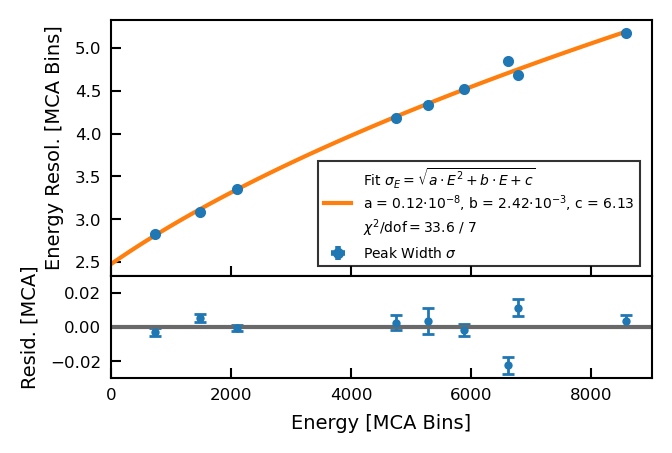

In [85]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.peak_position, resol, yerr = resol_err, xerr = df_calibration.peak_position_unc,
            fmt = 'o', ms = 3, label = 'Peak Width $\sigma$', linewidth = 2)
x_val = x_val = np.linspace(0, np.array(df_calibration.peak_position)[-1], 100)
ax0.plot(x_val, resolFunc(x_val, popt_relresol[2], popt_relresol[1]/cal_CE_a, popt_relresol[0]/cal_CE_a**2), 
         label = 'Fit $\sigma_E = \sqrt{a \cdot E^2 + b \cdot E +c}$'
         +'\na = '+str(round(1e8*popt_relresol[2],2))+'$\cdot 10^{-8}$' 
         +', b = '+str(round(1e3*popt_relresol[1]/cal_CE_a,2))+'$\cdot 10^{-3}$' 
         +', c = '+str(round(1e0*popt_relresol[0]/cal_CE_a**2,2))
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resol. [MCA Bins]')
ax0.set_xlim(left = 0)

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.peak_position, residuals_conv, yerr = residuals_err_conv,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals_conv), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [MCA Bins]')
ax1.set_ylabel('Resid. [MCA]')
val_lim = max(np.abs(1.1*np.max(residuals_conv+residuals_err_conv)), np.abs(1.1*np.min(residuals_conv-residuals_err_conv)))
ax1.set_ylim(-val_lim, val_lim)
ax1.set_xlim(left = 0)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)

legend = ax0.legend(loc=4, bbox_to_anchor=(0.99,0.01), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolution_fit_residuals_adc.png', bbox_inches='tight')
plt.show()

In [86]:
print('MCA_ch Resolution MCA_ch_error Resolution_error')
out = np.array([np.array(df_calibration.peak_position), np.array(resol), 
                np.array(df_calibration.peak_width), np.array(resol_err)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Resolution MCA_ch_error Resolution_error
739.2981195005566 2.832400511792867 2.832400511792867 0.014581674634352403
1489.2287715785033 3.0891430560456534 3.0891430560456534 0.015241857998604084
2096.608283802872 3.351679244576803 3.351679244576803 0.009782967193421295
4747.20208970753 4.185116083495722 4.185116083495722 0.026033501590142456
5286.734500343066 4.332106089532494 4.332106089532494 0.046645405342238044
5876.285844374283 4.525884001642418 4.525884001642418 0.022304014810903276
6618.933129066852 4.845328318757701 4.845328318757701 0.02966126567029487
6778.981100156106 4.683227421929863 4.683227421929863 0.02937161864961992
8583.702633940307 5.171820109974334 5.171820109974334 0.022225403805275108


In [87]:
print('MCA_ch Residual MCA_ch_error Residual_error')
out = np.array([np.array(df_calibration.peak_position), np.array(residuals_conv), 
                np.array(df_calibration.peak_width), np.array(residuals_err_conv)]).T
for el in out:
    print(str(el[0])+' '+str(el[1])+' '+str(el[2])+' '+str(el[3]))

MCA_ch Residual MCA_ch_error Residual_error
739.2981195005566 -0.0028940105718899918 2.832400511792867 0.002494004132971443
1489.2287715785033 0.0052640327973618286 3.0891430560456534 0.002529551490399153
2096.608283802872 -0.0005086800801076773 3.351679244576803 0.0016339442358295228
4747.20208970753 0.002430519703573419 4.185116083495722 0.004274543936300681
5286.734500343066 0.0034443305433005575 4.332106089532494 0.007651506845757322
5876.285844374283 -0.0018564482018708374 4.525884001642418 0.0036636697071564567
6618.933129066852 -0.02214686026190384 4.845328318757701 0.0048683913199146596
6778.981100156106 0.011197801585366426 4.683227421929863 0.004820743245885388
8583.702633940307 0.0035328198071219474 5.171820109974334 0.0036502454020517815


## Resolution FWHM

In [88]:
sigma_to_fwhm = 2*np.sqrt(2*np.log(2))
print('factor Gaussian sigma to FWHM: '+str(sigma_to_fwhm))

factor Gaussian sigma to FWHM: 2.3548200450309493


In [89]:
popt_relresol_fwhm = popt_relresol*sigma_to_fwhm**2
popt_relresol_fwhm

array([9.14155425e-01, 2.19741104e-03, 6.56354823e-09])

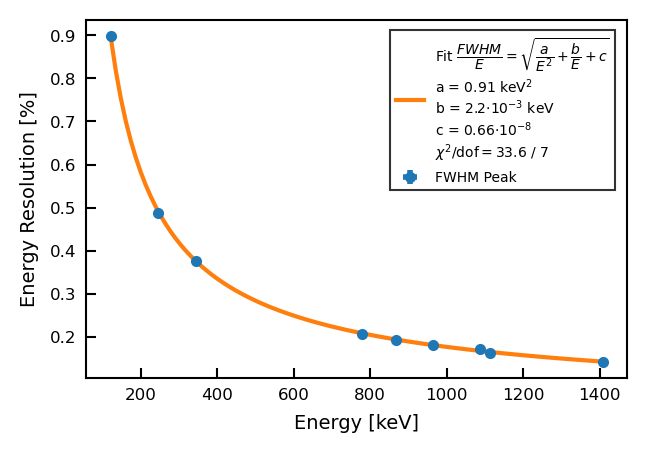

In [90]:
plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit.png', bbox_inches='tight')
plt.show()

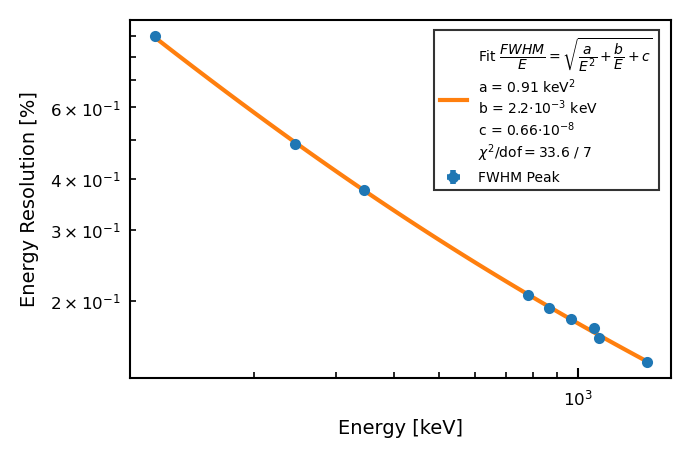

In [91]:
plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_loglog.png', bbox_inches='tight')
plt.show()

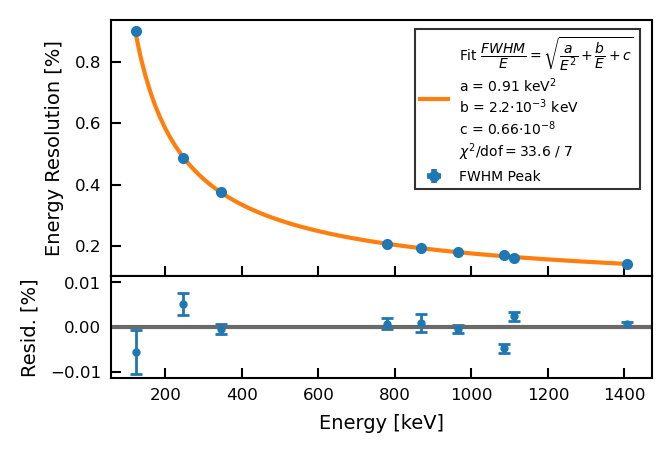

In [92]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*residuals, yerr = sigma_to_fwhm*100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(sigma_to_fwhm*100*1.1*np.max(residuals+residuals_err)), np.abs(sigma_to_fwhm*100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_residuals.png', bbox_inches='tight')
plt.show()

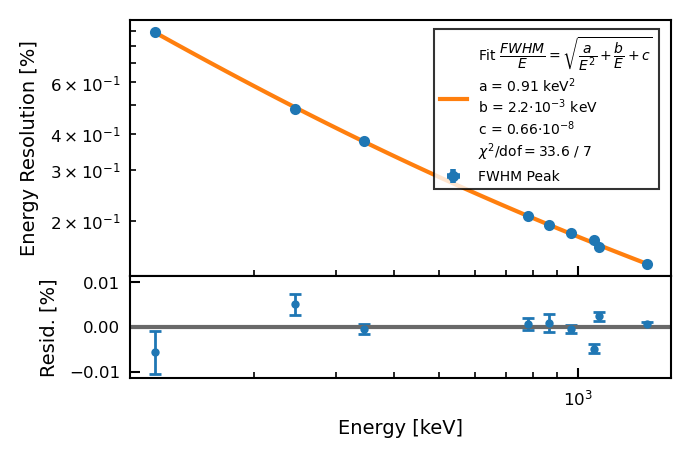

In [93]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 

ax0 = plt.subplot(gs[0])
ax0.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
ax0.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax0.set_ylabel('Energy Resolution [%]')
ax0.set_xscale('log'); ax0.set_yscale('log');

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*residuals, yerr = sigma_to_fwhm*100*residuals_err,
             fmt='o', ms=2, capsize=2, linewidth = 1, label = '$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
ax1.axhline(y=np.mean(residuals), color = 'dimgray')
plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
#yticks[-1].label1.set_visible(False)
ax1.set_xlabel('Energy [keV]')
ax1.set_ylabel('Resid. [%]')
val_lim = max(np.abs(sigma_to_fwhm*100*1.1*np.max(residuals+residuals_err)), np.abs(sigma_to_fwhm*100*1.1*np.min(residuals-residuals_err)))
ax1.set_ylim(-val_lim, val_lim)
#ax1.set_yticks(np.arange(-0.15, 0.16, step=0.15))
#plt.xlim(0, 16383)
ax1.set_xscale('log'); 

legend = ax0.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.subplots_adjust(hspace=.0)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_residuals_loglog.png', bbox_inches='tight')
plt.show()

In [94]:
'''matplotlib.rcParams['figure.figsize'] = (3.4908516673585166/1.2, 2.327234444905678)

plt.errorbar(df_calibration.e_lit, sigma_to_fwhm*100*rel_resol, 
             yerr = sigma_to_fwhm*rel_resol_err, xerr = df_calibration.e_err_lit,
             fmt = 'o', ms = 3, label = 'FWHM Peak', linewidth = 2)
#plt.plot(df_calibration.e_lit, relresolFunc(df_calibration.e_lit, 4.43e-1, 7.70e-4, 2.35e-7))
x_val = np.linspace(np.array(df_calibration.e_lit)[0], np.array(df_calibration.e_lit)[-1], 100)
plt.plot(x_val, 100*relresolFunc(x_val, *popt_relresol_fwhm), label = 'Fit $\dfrac{FWHM}{E} = \sqrt{\dfrac{a}{E^2} + \dfrac{b}{E} +c}$'
         +'\na = '+str(round(popt_relresol_fwhm[0],2))+' keV$^2$' 
         +'\nb = '+str(round(1e3*popt_relresol_fwhm[1],2))+'$\cdot 10^{-3}$ keV' 
         +'\nc = '+str(round(1e8*popt_relresol_fwhm[2],2))+'$\cdot 10^{-8}$'
         +'\n$\chi^2 / \mathrm{dof} = $'+str(round(chi2,1))+' / '+str(int(dof)))
#plt.xscale('log'); plt.yscale('log');
plt.xlabel('Energy [keV]')
plt.ylabel('Energy Resolution [%]')
legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)
if save_plots:
    plt.savefig(filename_suffix_save+'_resolutionfwhm_fit_aspectratio.png', bbox_inches='tight')
plt.show()''';

# Other Stuff

In [95]:
print(cal_CE)
print(cal_EC)

(0.16397043345144954, 0.525435801458153)
(6.098660465492352, -3.2044545495071266)


In [96]:
linFunc(np.array([100, 2700]), *cal_EC)

array([  606.661592  , 16463.17880228])

In [97]:
linFunc(np.array([0, 16383]), *cal_CE)

array([5.25435801e-01, 2.68685305e+03])

In [98]:
Energy_check = 1332.49
Energy_check*relresolFunc(Energy_check, *popt_relresol_fwhm)

1.9631193120187869

In [99]:
cal_202105_CE_a = 0.16480422280063092
cal_202105_CE_b = 0.49977182490554006
cal_202105_CE = (cal_202105_CE_a, cal_202105_CE_b)
cal_202105_EC_a = 1/cal_202105_CE_a
cal_202105_EC_b = -cal_202105_CE_b/cal_202105_CE_a
cal_202105_EC = (cal_202105_EC_a, cal_202105_EC_b)

def func_e_to_adc(x = np.array([100, 2700]), a = cal_202105_EC_a, b = cal_202105_EC_b):
    res = a*x+b
    return res
def func_adc_to_e(x = np.array([0, 16383]), a = cal_202105_CE_a, b = cal_202105_CE_b):
    res = a*x+b
    return res

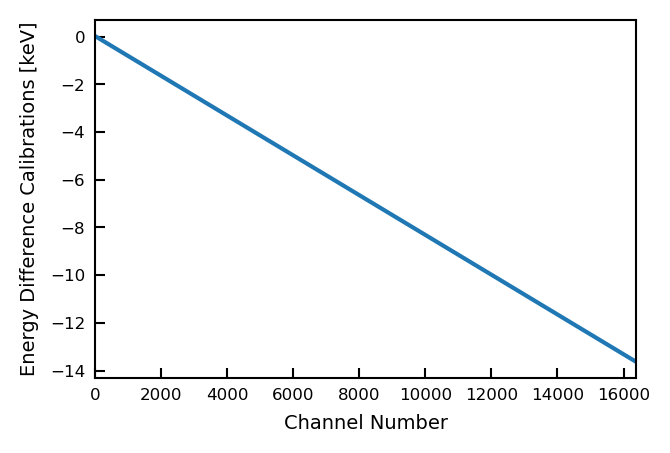

In [100]:
x_list = np.linspace(0,16383,10)
plt.plot(x_list, linFunc(x_list, *popt) - func_adc_to_e(x_list))
plt.xlim(0,16383)
plt.xlabel('Channel Number')
plt.ylabel('Energy Difference Calibrations [keV]')
if save_plots:
    plt.savefig(filename_suffix_save+'_diff_to_calib202105.png', bbox_inches='tight')
plt.show()

In [101]:
p_resol_202105 = (8.97573110e-01, 2.29320769e-03, 1.52084498e-26)

def relresolFunc_old(E, a=p_resol_202105[0], b=p_resol_202105[1], c=p_resol_202105[2]):
    relresol = np.sqrt(a/E**2 + b/E + c)
    return relresol

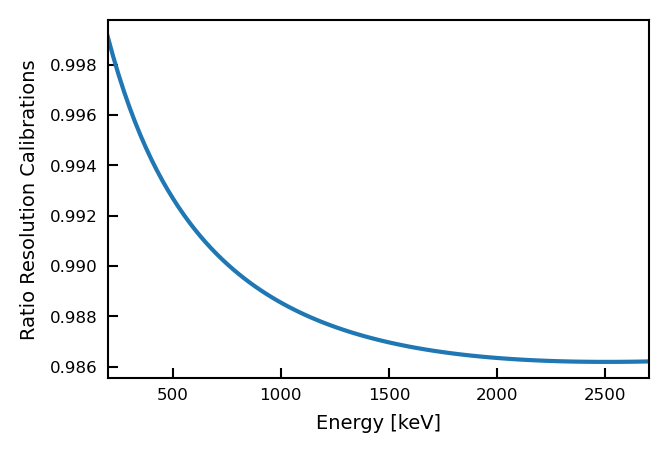

In [102]:
x_list = np.linspace(200,2700,100)

plt.plot(x_list, relresolFunc(x_list, *popt_relresol_fwhm) / relresolFunc_old(x_list))
plt.xlim(200,2700)
plt.xlabel('Energy [keV]')
plt.ylabel('Ratio Resolution Calibrations')
if save_plots:
    plt.savefig(filename_suffix_save+'_ratioresol_to_calib202105.png', bbox_inches='tight')
plt.show()